<h1>Neural Network Prediction</h1>
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h2>Import of libraries and files</h2>

In [33]:
# importing the required libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
# importing the prepared data

# path is depending on this machine, change to "./data/" later!
file_path = "./data/"

# load all 12 data frames
df_census_1H = pd.read_csv(f"{file_path}features_census_1H.csv")
df_census_2H = pd.read_csv(f"{file_path}features_census_2H.csv")
df_census_6H = pd.read_csv(f"{file_path}features_census_6H.csv")
df_census_24H = pd.read_csv(f"{file_path}features_census_24H.csv")

df_hex_6_1H = pd.read_csv(f"{file_path}features_hex_6_1H.csv")
df_hex_6_2H = pd.read_csv(f"{file_path}features_hex_6_2H.csv")
df_hex_6_6H = pd.read_csv(f"{file_path}features_hex_6_6H.csv")
df_hex_6_24H = pd.read_csv(f"{file_path}features_hex_6_24H.csv")

df_hex_7_1H = pd.read_csv(f"{file_path}features_hex_7_1H.csv")
df_hex_7_2H = pd.read_csv(f"{file_path}features_hex_7_2H.csv")
df_hex_7_6H = pd.read_csv(f"{file_path}features_hex_7_6H.csv")
df_hex_7_24H = pd.read_csv(f"{file_path}features_hex_7_24H.csv")

<h2>Sampling and pre-processing of the data</h2>

In [35]:
# drawing random samples from each data frame considering limited computing power
random_seed = 42

# for census tract resolution
df_census_1H_subset = df_census_1H.sample(n=5000, random_state=random_seed)
df_census_2H_subset = df_census_2H.sample(n=5000, random_state=random_seed)
df_census_6H_subset = df_census_6H.sample(n=5000, random_state=random_seed)
df_census_24H_subset = df_census_24H.sample(n=5000, random_state=random_seed)

# for hexagon 6 resolution
df_hex_6_1H_subset = df_hex_6_1H.sample(n=5000, random_state=random_seed)
df_hex_6_2H_subset = df_hex_6_2H.sample(n=5000, random_state=random_seed)
df_hex_6_6H_subset = df_hex_6_6H.sample(n=5000, random_state=random_seed)
df_hex_6_24H_subset = df_hex_6_24H.sample(n=5000, random_state=random_seed)

# for hexagon 7 resolution
df_hex_7_1H_subset = df_hex_7_1H.sample(n=5000, random_state=random_seed)
df_hex_7_2H_subset = df_hex_7_2H.sample(n=5000, random_state=random_seed)
df_hex_7_6H_subset = df_hex_7_6H.sample(n=5000, random_state=random_seed)
df_hex_7_24H_subset = df_hex_7_24H.sample(n=5000, random_state=random_seed)

In [36]:
# data preprocessing
def preprocess_data(df, train_ratio=0.75, validation_ratio=0.15):
    features = ['num_hotels', 'num_bars', 'dist_centre', 'perc_transport',
                'evening_commuting_week', 'bar_hours','hour','perc_commerc',
                'perc_resid','perc_open','temp']
    target = 'rides'
    

    # check for NaN values and handling them
    if df[features].isnull().sum().sum() > 0:
        print("NaN values found in features. Filling NaN values with the mean of each column.")
        df[features] = df[features].fillna(df[features].mean())
    
    if df[target].isnull().sum() > 0:
        print("NaN values found in target. Dropping rows with NaN values in the target column.")
        df = df.dropna(subset=[target])
    
    X = df[features]
    y = df[target]
    
    # splitting data into train and test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_ratio, random_state=random_seed)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=validation_ratio / (1 - train_ratio), random_state=random_seed)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

<h2>Initial neural network architecture</h2>

In [37]:
# nn model architecture
# with variable number of layers and neurons
# for grid search optimization

def create_model(num_layers=3, num_neurons=64, learning_rate=0.01, dropout_rate=0.2):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))
    
    for _ in range(num_layers):
        model.add(layers.Dense(num_neurons, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


<h2>Applying grid search for hyperparameter optimization</h2>

In [38]:
# grid search for hyperparameter tuning

# initializing the wrapper class
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, num_layers=3, num_neurons=64, learning_rate=0.01, dropout_rate=0.2, epochs=10, batch_size=32):
        self.num_layers = num_layers
        self.num_neurons = num_neurons
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = create_model(num_layers=self.num_layers, num_neurons=self.num_neurons, 
                                  learning_rate=self.learning_rate, dropout_rate=self.dropout_rate)
    
    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)  

In [39]:
# preprocessing the datasets for training
datasets = {
    'census_1H': preprocess_data(df_census_1H_subset),
    'census_2H': preprocess_data(df_census_2H_subset),
    'census_6H': preprocess_data(df_census_6H_subset),
    'census_24H': preprocess_data(df_census_24H_subset),
    'hex6_1H': preprocess_data(df_hex_6_1H_subset),
    'hex6_2H': preprocess_data(df_hex_6_2H_subset),
    'hex6_6H': preprocess_data(df_hex_6_6H_subset),
    'hex6_24H': preprocess_data(df_hex_6_24H_subset),
    'hex7_1H': preprocess_data(df_hex_7_1H_subset),
    'hex7_2H': preprocess_data(df_hex_7_2H_subset),
    'hex7_6H': preprocess_data(df_hex_7_6H_subset),
    'hex7_24H': preprocess_data(df_hex_7_24H_subset),
}

NaN values found in features. Filling NaN values with the mean of each column.
NaN values found in features. Filling NaN values with the mean of each column.


In [40]:
# setting the grid search parameters
param_grid = {
    'num_layers': [3, 4, 5],
    'num_neurons': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout_rate': [0.1, 0.2, 0.3],
    'epochs': [20, 30, 40],
    'batch_size': [16, 32, 64] 
}

In [41]:
# performing grid search on census_1H data frame to tune the NN hyperparameters 
X_train, X_val, X_test, y_train, y_val, y_test = datasets['census_1H']
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

model = KerasRegressorWrapper()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found from grid search: {best_params}")

c:\Users\janis\aaa-2024-group-5\aaaenv\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found from grid search: {'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 40, 'learning_rate': 0.001, 'num_layers': 4, 'num_neurons': 64}


<h2>Training & evaluating the neural network for different spatio-temporal resolutions</h2>

In [42]:
# training the model for the different spatio-temporal resolutions

# initializing a dictionary for storing evaluation results
results = {
    'dataset': [],
    'r2': [],
    'rmse': [],
    'mae': []
}

# applying the via grid search identified hyperparameters to the remaining 11 data frames
for name, (X_train, X_val, X_test, y_train, y_val, y_test) in datasets.items():
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # defining new model architecture based on tuned hyperparameters
    model = KerasRegressorWrapper(
        num_layers=best_params['num_layers'],
        num_neurons=best_params['num_neurons'],
        learning_rate=best_params['learning_rate'],
        dropout_rate=best_params['dropout_rate'],
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size']
    )
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    # calculating evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # storing the results in the dictionary for the visualization step
    results['dataset'].append(name)
    results['rmse'].append(rmse)
    results['r2'].append(r2)
    results['mae'].append(mae)
    
    # printing the evaluations metrics 
    print(f"Results for {name}:")
    print(f"R^2 Score: {r2}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Error: {mae}")
    print()

24/24 [==============================] - 0s 653us/step
Results for census_1H:
R^2 Score: 0.7983283988826191
Root Mean Squared Error: 18.566991764281806
Mean Absolute Error: 4.961093829472859

24/24 [==============================] - 0s 566us/step
Results for census_2H:
R^2 Score: 0.7336012025523533
Root Mean Squared Error: 29.70878034277637
Mean Absolute Error: 8.225677896340688

24/24 [==============================] - 0s 609us/step
Results for census_6H:
R^2 Score: 0.7311252575138195
Root Mean Squared Error: 57.10815387517035
Mean Absolute Error: 12.974832994778952

24/24 [==============================] - 0s 566us/step
Results for census_24H:
R^2 Score: 0.8561412372514695
Root Mean Squared Error: 130.88083922924147
Mean Absolute Error: 31.45942356109619

24/24 [==============================] - 0s 566us/step
Results for hex6_1H:
R^2 Score: 0.8224781027552132
Root Mean Squared Error: 132.3560363623347
Mean Absolute Error: 37.90625598780314

24/24 [==============================] - 0s

<h2>Visualizing model performance</h2>

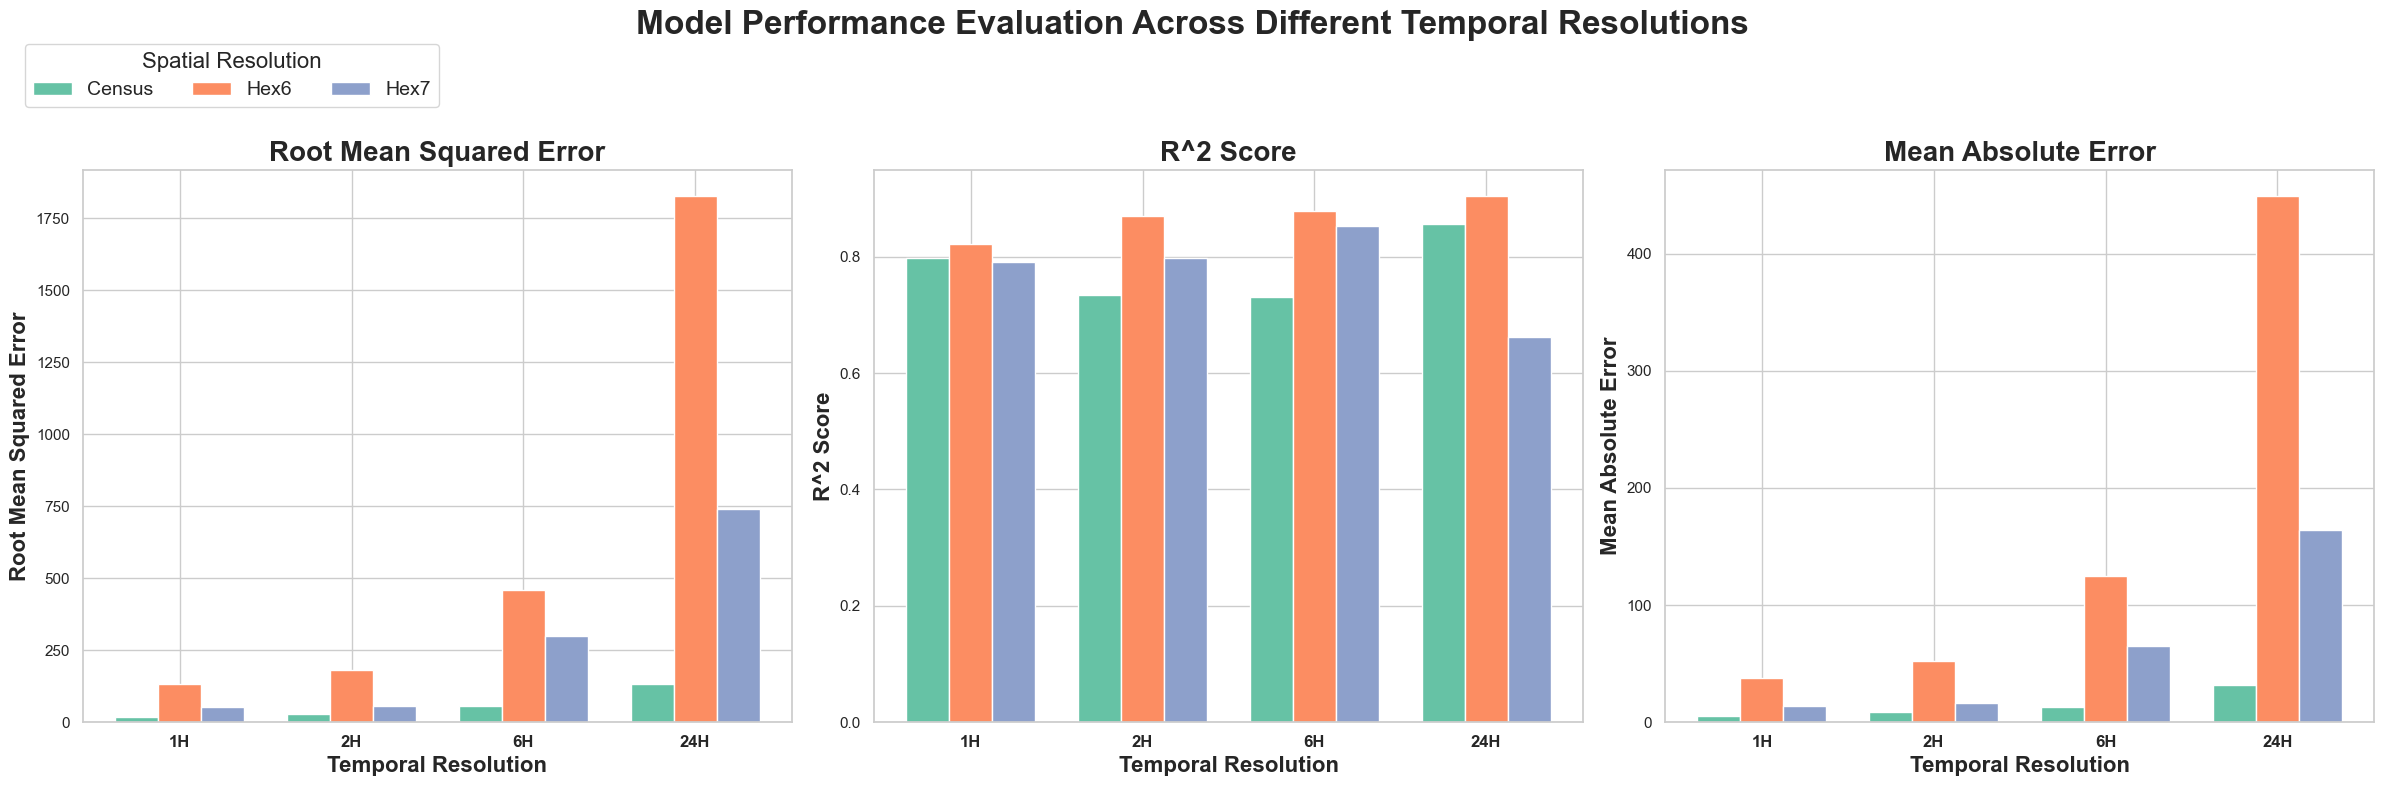

In [43]:
# setting style and colour palette
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# layout definition
fig, axs = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Model Performance Evaluation Across Different Temporal Resolutions', fontsize=24, weight='bold')

# defining resolutions and spatial models for the bars
time_resolutions = ['1H', '2H', '6H', '24H']
models = ['Census', 'Hex6', 'Hex7']

# defining corresponding indices in the results dictionary
indices = {
    'Census': [0, 1, 2, 3],
    'Hex6': [4, 5, 6, 7],
    'Hex7': [8, 9, 10, 11]
}

metrics = ['rmse', 'r2', 'mae']
metric_names = ['Root Mean Squared Error', 'R^2 Score', 'Mean Absolute Error']

# plotting the figures
for i, metric in enumerate(metrics):
    bars = []
    labels = []
    
    # iterating through our different time resolutions
    for j, time in enumerate(time_resolutions):
        # collecting values for each model at a given time resolution
        bars.append([results[metric][indices[model][j]] for model in models])
        labels.append(f'{time}')
    
    # creating bar positions
    x = np.arange(len(time_resolutions))
    width = 0.25  
    
    # plotting bars for each model
    for k, model in enumerate(models):
        axs[i].bar(x + k * width, [bar[k] for bar in bars], width, label=model, color=palette[k])
    
    axs[i].set_xticks(x + width)
    axs[i].set_xticklabels(labels, fontsize=12, weight='bold')
    axs[i].set_title(metric_names[i], fontsize=20, weight='bold')
    axs[i].set_xlabel('Temporal Resolution', fontsize=16, weight='bold')
    axs[i].set_ylabel(metric_names[i], fontsize=16, weight='bold')

# defining the legend for the bars and setting its position
handles, labels = axs[0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.1, 0.95), fontsize=14, title='Spatial Resolution', title_fontsize='16')

plt.tight_layout(rect=[0, 0, 1, 0.9])  

# final plot result
plt.show()
